In [9]:
# Runtime / env info
import torch, os, sys, random, numpy as np
print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA  :", torch.version.cuda if torch.cuda.is_available() else "CPU-only")
print("GPU   :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Paths (you uploaded directly to /content)
BASE = "/content"
ZIP_PATH = os.path.join(BASE, "img_align_celeba.zip")
ID_PATH  = os.path.join(BASE, "identity_CelebA.txt")
IMG_DIR  = os.path.join(BASE, "img_align_celeba")
SPLIT_DIR = os.path.join(BASE, "splits"); os.makedirs(SPLIT_DIR, exist_ok=True)
CKPT_DIR  = os.path.join(BASE, "checkpoints"); os.makedirs(CKPT_DIR, exist_ok=True)

# A100-friendly defaults
IMG_SIZE   = 256
BATCH_SIZE = 128
EPOCHS_WARMUP = 3
EPOCHS_FT     = 12
LABEL_SMOOTH  = 0.07
WEIGHT_DECAY  = 1e-4
LR_HEAD_WARM  = 1e-3
LR_FT         = 3e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch : 2.8.0+cu126
CUDA  : 12.6
GPU   : NVIDIA A100-SXM4-80GB


device(type='cuda')

In [10]:
import glob, zipfile

print("Files in /content/:")
for p in sorted(glob.glob("/content/*")):
    print(" -", os.path.basename(p))

os.makedirs(IMG_DIR, exist_ok=True)
already = any(name.lower().endswith(".jpg") for name in os.listdir(IMG_DIR)) if os.path.exists(IMG_DIR) else False

if not already:
    assert os.path.exists(ZIP_PATH), f"Missing zip at {ZIP_PATH}"
    print("Extracting images (few minutes)…")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(IMG_DIR)
    print("Done.")
else:
    print("Images already extracted.")

jpgs = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
print(f"Found {len(jpgs):,} images in {IMG_DIR}")

print("\nFirst 5 lines of identity_CelebA.txt:")
with open(ID_PATH, "r") as fh:
    for i, line in enumerate(fh):
        if i >= 5: break
        print(line.strip())


Files in /content/:
 - checkpoints
 - identity_CelebA.txt
 - img_align_celeba
 - img_align_celeba.zip
 - sample_data
 - splits
Extracting images (few minutes)…
Done.
Found 0 images in /content/img_align_celeba

First 5 lines of identity_CelebA.txt:
000001.jpg 2880
000002.jpg 2937
000003.jpg 8692
000004.jpg 5805
000005.jpg 9295


In [11]:
import os, glob

def count_jpgs(path):
    return len(glob.glob(os.path.join(path, "*.jpg")))

print("Current IMG_DIR:", IMG_DIR)
print("Direct JPGs in IMG_DIR:", count_jpgs(IMG_DIR))

# If none found, look one or two levels deeper and pick the folder with most JPGs
if count_jpgs(IMG_DIR) == 0:
    candidates = []
    # one level down
    for d1 in glob.glob(os.path.join(IMG_DIR, "*")):
        if os.path.isdir(d1):
            candidates.append((d1, count_jpgs(d1)))
            # two levels down
            for d2 in glob.glob(os.path.join(d1, "*")):
                if os.path.isdir(d2):
                    candidates.append((d2, count_jpgs(d2)))

    # choose the subfolder with max jpgs
    if candidates:
        best_dir, best_cnt = max(candidates, key=lambda x: x[1])
        if best_cnt > 0:
            IMG_DIR = best_dir
            print(f"Adjusted IMG_DIR -> {IMG_DIR}  (found {best_cnt} JPGs)")
        else:
            print("No JPGs found in subfolders. Check your zip contents.")
    else:
        print("No subfolders present under IMG_DIR.")

# Recount after adjustment
jpgs = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
print(f"Now seeing {len(jpgs):,} images in {IMG_DIR}")


Current IMG_DIR: /content/img_align_celeba
Direct JPGs in IMG_DIR: 0
Adjusted IMG_DIR -> /content/img_align_celeba/img_align_celeba/img_align_celeba  (found 202599 JPGs)
Now seeing 202,599 images in /content/img_align_celeba/img_align_celeba/img_align_celeba


In [12]:
import os, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# If df isn't in memory, rebuild it quickly:
if 'df' not in globals():
    rows = []
    with open(ID_PATH, "r", errors="ignore") as fh:
        for line in fh:
            p = line.strip().split()
            if len(p) == 2:
                rows.append((p[0], int(p[1])))
    df = pd.DataFrame(rows, columns=["filename", "orig_id"])
    have = set(os.listdir(IMG_DIR))
    df = df[df["filename"].isin(have)].reset_index(drop=True)

print("Aligned with images:", df.shape)

# 1) Filter rare classes
MIN_IMAGES_PER_CLASS = 10  # Increased to 10 to ensure at least 2 samples per class for splitting
counts = df["orig_id"].value_counts()
keep_ids = set(counts[counts >= MIN_IMAGES_PER_CLASS].index)
df_f = df[df["orig_id"].isin(keep_ids)].reset_index(drop=True)

print(f"Before: {len(df):,} imgs, {df['orig_id'].nunique():,} classes")
print(f" After: {len(df_f):,} imgs, {df_f['orig_id'].nunique():,} classes (>= {MIN_IMAGES_PER_CLASS}/class)")

# 2) Reindex labels 0..C-1
uids = sorted(df_f["orig_id"].unique())
oid2nid = {oid:i for i, oid in enumerate(uids)}
df_f["label"] = df_f["orig_id"].map(oid2nid)
num_classes = len(uids)
print("Classes after filter:", num_classes)

assert num_classes > 1 and len(df_f) > 0, "Too few samples/classes after filtering."

# 3) Stratified 70/15/15
X, y = df_f["filename"].values, df_f["label"].values

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
train_idx, temp_idx = next(sss1.split(X, y))
X_train, y_train = X[train_idx], y[train_idx]
X_temp,  y_temp  = X[temp_idx],  y[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
val_idx, test_idx = next(sss2.split(X_temp, y_temp))
X_val, y_val   = X_temp[val_idx],  y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")

# Recreate SPLIT_DIR after IMG_DIR might have been adjusted
os.makedirs(SPLIT_DIR, exist_ok=True)

# 4) Save splits  (<<< the lines that broke before)
pd.DataFrame({"filename": X_train, "label": y_train}).to_csv(os.path.join(SPLIT_DIR, "train.csv"), index=False)
pd.DataFrame({"filename": X_val,   "label": y_val  }).to_csv(os.path.join(SPLIT_DIR, "val.csv"),   index=False)
pd.DataFrame({"filename": X_test,  "label": y_test }).to_csv(os.path.join(SPLIT_DIR, "test.csv"),  index=False)

print("Splits saved to:", SPLIT_DIR)

# 5) Quick presence check
sample_path = os.path.join(IMG_DIR, X_train[0])
print("Sample file exists:", os.path.exists(sample_path), "->", sample_path)

Aligned with images: (202599, 2)
Before: 202,599 imgs, 10,177 classes
 After: 193,569 imgs, 8,369 classes (>= 10/class)
Classes after filter: 8369
Train: 135,498 | Val: 29,035 | Test: 29,036
Splits saved to: /content/splits
Sample file exists: True -> /content/img_align_celeba/img_align_celeba/img_align_celeba/199098.jpg


In [13]:
import os
import pandas as pd
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image

IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

train_tfms = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(IMNET_MEAN, IMNET_STD),
])

eval_tfms = T.Compose([
    T.Resize(int(IMG_SIZE*1.1)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(IMNET_MEAN, IMNET_STD),
])

class CelebADataset(Dataset):
    def __init__(self, csv_path, img_dir, transform):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row["filename"])).convert("RGB")
        img = self.transform(img) if self.transform else img
        return img, int(row["label"])

train_ds = CelebADataset(os.path.join(SPLIT_DIR, "train.csv"), IMG_DIR, train_tfms)
val_ds   = CelebADataset(os.path.join(SPLIT_DIR, "val.csv"),   IMG_DIR, eval_tfms)
test_ds  = CelebADataset(os.path.join(SPLIT_DIR, "test.csv"),  IMG_DIR, eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

len(train_ds), len(val_ds), len(test_ds)


(135498, 29035, 29036)

In [14]:
import torch, torch.nn as nn
import torchvision.models as models

# recover class count from split files
num_classes = pd.read_csv(os.path.join(SPLIT_DIR, "train.csv"))["label"].nunique()

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)
model = model.to(device)

sum(p.numel() for p in model.parameters())/1e6


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 173MB/s]


12.944561

In [15]:
import torch
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim

# freeze backbone
for p in model.features.parameters():
    p.requires_grad = False

optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad],
                        lr=LR_HEAD_WARM, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
scaler = GradScaler(enabled=True)

def run_epoch(loader, train=True):
    model.train(mode=train)
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = torch.as_tensor(y, device=device)
        if train: optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            logits = model(x)
            loss = criterion(logits, y)
        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        loss_sum += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += x.size(0)
    return loss_sum/total, correct/total

best_val = 0.0
for e in range(1, EPOCHS_WARMUP+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader,   False)
    best_val = max(best_val, va_acc)
    print(f"[Warmup {e}/{EPOCHS_WARMUP}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | val_loss={va_loss:.4f} val_acc={va_acc:.4f}")


/tmp/ipython-input-6502190.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
/tmp/ipython-input-6502190.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


[Warmup 1/3] tr_loss=8.6169 tr_acc=0.0143 | val_loss=7.6768 val_acc=0.0400
[Warmup 2/3] tr_loss=6.4946 tr_acc=0.1005 | val_loss=7.2265 val_acc=0.0702
[Warmup 3/3] tr_loss=5.5640 tr_acc=0.1893 | val_loss=7.0615 val_acc=0.0899


In [16]:
# Unfreeze top portion of backbone (here: last ~1/2 of feature blocks)
unfreeze = False
for name, p in model.features.named_parameters():
    # mobilenet has features[0..18]; unfreeze higher indices
    block_idx = int(name.split('.')[0])
    if block_idx >= 10:  # adjust threshold to unfreeze more/less
        p.requires_grad = True
        unfreeze = True

trainable = [p for p in model.parameters() if p.requires_grad]
print("Trainable params (M):", sum(p.numel() for p in trainable)/1e6)

# New optimizer for fine-tuning (lower LR)
optimizer = optim.AdamW(trainable, lr=LR_FT, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_FT)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
scaler = GradScaler(enabled=True)

def evaluate(loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), torch.tensor(y).to(device, non_blocking=True)
            with autocast(enabled=True):
                logits = model(x)
                loss = criterion(logits, y)
            loss_sum += loss.item() * x.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += x.size(0)
            all_preds.append(pred.cpu())
            all_labels.append(y.cpu())
    import torch as T
    return loss_sum/total, correct/total, T.cat(all_preds), T.cat(all_labels)

best_val = 0.0
best_path = os.path.join(CKPT_DIR, f"mobilenetv2_best.pt")

for epoch in range(1, EPOCHS_FT+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc, _, _ = evaluate(val_loader)
    if va_acc > best_val:
        best_val = va_acc
        torch.save({"model": model.state_dict(), "num_classes": num_classes, "img_size": IMG_SIZE}, best_path)
    scheduler.step()
    print(f"[FT {epoch}/{EPOCHS_FT}] train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f} | best_val={best_val:.4f}")

print("Saved best checkpoint to:", best_path)


Trainable params (M): 12.759473


/tmp/ipython-input-2563652827.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
/tmp/ipython-input-6502190.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipython-input-2563652827.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device, non_blocking=True), torch.tensor(y).to(device, non_blocking=True)
/tmp/ipython-input-2563652827.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


[FT 1/12] train_loss=3.8260 acc=0.4558 | val_loss=4.9433 acc=0.2875 | best_val=0.2875
[FT 2/12] train_loss=2.9620 acc=0.6206 | val_loss=4.5409 acc=0.3511 | best_val=0.3511
[FT 3/12] train_loss=2.4950 acc=0.7233 | val_loss=4.2184 acc=0.4056 | best_val=0.4056
[FT 4/12] train_loss=2.1628 acc=0.8006 | val_loss=3.9981 acc=0.4456 | best_val=0.4456
[FT 5/12] train_loss=1.9215 acc=0.8595 | val_loss=3.8526 acc=0.4725 | best_val=0.4725
[FT 6/12] train_loss=1.7413 acc=0.9034 | val_loss=3.6255 acc=0.5164 | best_val=0.5164
[FT 7/12] train_loss=1.6035 acc=0.9362 | val_loss=3.5608 acc=0.5310 | best_val=0.5310
[FT 8/12] train_loss=1.5036 acc=0.9579 | val_loss=3.5224 acc=0.5409 | best_val=0.5409
[FT 9/12] train_loss=1.4313 acc=0.9714 | val_loss=3.4332 acc=0.5584 | best_val=0.5584
[FT 10/12] train_loss=1.3807 acc=0.9812 | val_loss=3.4155 acc=0.5637 | best_val=0.5637
[FT 11/12] train_loss=1.3485 acc=0.9856 | val_loss=3.3828 acc=0.5718 | best_val=0.5718
[FT 12/12] train_loss=1.3306 acc=0.9880 | val_loss=3

In [17]:
from sklearn.metrics import f1_score

ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])

val_loss, val_acc, val_pred, val_true = evaluate(val_loader)
test_loss, test_acc, test_pred, test_true = evaluate(test_loader)

val_f1  = f1_score(val_true.numpy(),  val_pred.numpy(),  average="macro")
test_f1 = f1_score(test_true.numpy(), test_pred.numpy(), average="macro")

print(f"VAL  - loss {val_loss:.4f} | acc {val_acc:.4f} | macro-F1 {val_f1:.4f}")
print(f"TEST - loss {test_loss:.4f} | acc {test_acc:.4f} | macro-F1 {test_f1:.4f}")


/tmp/ipython-input-2563652827.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device, non_blocking=True), torch.tensor(y).to(device, non_blocking=True)
/tmp/ipython-input-2563652827.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


VAL  - loss 3.3723 | acc 0.5765 | macro-F1 0.5568
TEST - loss 3.3296 | acc 0.5768 | macro-F1 0.5531


Upload a single image (jpg/png)…


Saving lol.jpg to lol (1).jpg
Image: /content/lol (1).jpg
Predicted label index: 2891
Predicted celebrity ID: 3401
Confidence: 0.905


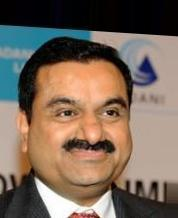

In [22]:
# === Single-photo demo: upload an image -> print predicted celebrity ID ===
import os, glob, numpy as np, pandas as pd, torch, torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
import torchvision.models as models
from IPython.display import display
try:
    from google.colab import files
except Exception:
    files = None  # not in Colab

# ---- Required paths (edit ONLY if your paths differ) ----
BASE       = "/content"
SPLIT_DIR  = os.path.join(BASE, "splits")
ID_PATH    = os.path.join(BASE, "identity_CelebA.txt")
CKPT_PATH  = os.path.join(BASE, "checkpoints", "mobilenetv2_best.pt")

# Try to reuse existing IMG_DIR; else auto-detect folder with most JPGs
try:
    IMG_DIR
except NameError:
    IMG_DIR = "/content/img_align_celeba"
def _jpg_count(p): return len(glob.glob(os.path.join(p, "*.jpg"))) if os.path.isdir(p) else 0
if _jpg_count(IMG_DIR) == 0:
    cands = []
    for r in ["/content/img_align_celeba", "/content"]:
        for d,_,_ in os.walk(r):
            cnt = _jpg_count(d)
            if cnt > 1000:
                cands.append((cnt, d))
    if cands:
        IMG_DIR = max(cands, key=lambda x: x[0])[1]

# ---- Load model from checkpoint ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert os.path.exists(CKPT_PATH), f"Checkpoint not found: {CKPT_PATH}"
ckpt = torch.load(CKPT_PATH, map_location=device)
num_classes = int(ckpt.get("num_classes"))
IMG_SIZE    = int(ckpt.get("img_size", 256))

model = models.mobilenet_v2(weights=None)
in_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(in_features, num_classes)
model.load_state_dict(ckpt["model"], strict=True)
model.eval().to(device)

# ---- Build label_index -> original CelebA ID map ----
assert os.path.exists(ID_PATH), f"identity file not found: {ID_PATH}"
fname_to_orig = {}
with open(ID_PATH, "r", errors="ignore") as fh:
    for line in fh:
        p = line.strip().split()
        if len(p) == 2:
            fname_to_orig[p[0]] = int(p[1])

dfs = []
for name in ["train.csv", "val.csv", "test.csv"]:
    p = os.path.join(SPLIT_DIR, name)
    assert os.path.exists(p), f"Missing split file: {p}"
    dfs.append(pd.read_csv(p))
all_df = pd.concat(dfs, ignore_index=True)

label_to_orig = {}
for lbl, grp in all_df.groupby("label"):
    # take any filename for this label to recover original ID
    for fn in grp["filename"]:
        if fn in fname_to_orig:
            label_to_orig[int(lbl)] = int(fname_to_orig[fn])
            break
assert len(label_to_orig) == num_classes, "Label→OrigID map incomplete. Recheck splits/identity file."

# ---- Inference transform ----
IMNET_MEAN = [0.485, 0.456, 0.406]; IMNET_STD = [0.229, 0.224, 0.225]
infer_tfms = T.Compose([
    T.Resize(int(IMG_SIZE*1.1)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(IMNET_MEAN, IMNET_STD),
])

def predict_image(image_path: str):
    """Loads a single image, prints predicted label index and CelebA ID, and shows the image."""
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = Image.open(image_path).convert("RGB")
    x = infer_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    pred_label = int(np.argmax(probs))
    conf = float(np.max(probs))
    pred_orig_id = label_to_orig.get(pred_label, None)

    print("Image:", image_path)
    print(f"Predicted label index: {pred_label}")
    print(f"Predicted celebrity ID: {pred_orig_id}")
    print(f"Confidence: {conf:.3f}")
    display(img)

# ---- Upload & run prediction (Colab UI) ----
if files is not None:
    print("Upload a single image (jpg/png)…")
    uploaded = files.upload()  # opens a chooser UI
    for name in uploaded.keys():
        # Files are saved in /content/<name>
        predict_image(os.path.join("/content", name))
else:
    print("Not in Colab: call predict_image('/path/to/your_image.jpg') manually.")
